# Final Assignment

In this exercise, you will train a perceptron with a quadratic loss function using gradient descent, and visualize the evolution of the weights during training.

Consider a perceptron with the following features:

Activity rule $g(h)$:
$$
g(h)={1\over 1+e^{-h}}\ , \,\,h^\mu=\sum_{i=1}^Nw_ix_i^\mu+b
$$
where $b=-1$ is a fixed bias (same as in the code we wrote in class).
We will use the following loglikelihood function explored in Assignment 5:
\begin{align}
E={1\over 2}\sum_{\mu=1}^p\left[z^\mu-{g}(h^\mu)\right]^2
\end{align}
and logprior:
\begin{align}
E_{prior}= {\alpha\over 2}\sum_{i=1}^N w_i^2\
\end{align}
The gradient of the loglikelihood function is:
$$
{\partial E(w)\over\partial w_i}=-\sum_{\mu=1}^p\partial_h{g}(h^\mu)[z^\mu-{g}(h^\mu)]x_i^\mu \ ,
$$
and the derivative of the activity is:
$$
\partial_h{g}={g}(1-{g}) \ .
$$
The gradient descent learning rule obtained from the logposterior $M(w)=E(w)+E_{prior}(w)$ is thus
$$
\Delta w_i=\eta\left[\sum_{\mu=1}^p{g}(h^\mu)(1-{g}(h^\mu))[z^\mu-{g}(h^\mu)]x_i^\mu-\alpha w_i\right] \ . \label{cost}\tag{1}
$$  

- Start from the code we wrote in class, which you can find in the notebook MATH410_Perceptron0.ipynb in the Module 'Supervised learning coding session'. 
- Set $N=2$, and generate $p_1=100$ and $p_2=100$ 'separable' patterns with labels $z=0$ and $z=1$, respectively. The $p_1$ patterns with label $z=0$ are sampled from a gaussian distribution with mean $(x_1,x_2)=(-1,-1)$ (bottom left quadrant in the plane) and the $p_2$ patterns with label $z=1$ are sampled from a gaussian distribution with mean $(x_1,x_2)=(1,1)$ (top right quadrant in the plane). Both distributions have spread=0.5. 
- Visualize the generated patterns in the plane.
- Modify the code written in class to train the perceptron using gradient descent with the learning rule (\ref{cost}). Note: the only difference is the inclusion of the factor corresponding to the derivative of the activity rule.
- Train the perceptron with gradient descent. Use $T = 10000$ training steps, $\eta=0.001$ learning rate, and $\alpha=0.$  weight decay. Monitor learning by plotting the weights $w_1,w_2$ and the logposterior function $M(w)$ as function of the training epochs, as we did in class. Plot also the classification boundaries at the beginning and at the end of training, as we did in class: namely, in the plane $(x_1,x_2)$, plot the classified patterns, and the lines corresponding to the activity $g(h)=0$, and $g(h)=0.25$ and $g(h)=0.75$.
- Now train the perceptron with the same parameters as above, except now with a large weight decay parameter $\alpha=0.5$. Monitor learning as above. 
- Explain the difference between the case $\alpha=0.$ and the case $\alpha=0.5$. Hint: What is the size of the weights at the end of learning? 


In [1]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)

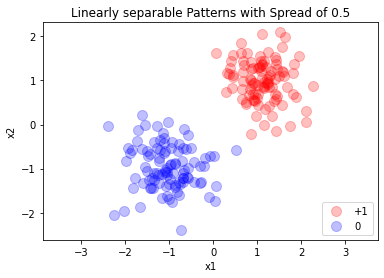

In [2]:
# code for generating the random patterns

def generate_patterns(spread,N=2,p1=100,p2=100,option='separable',plot=False):
    # spread parameter is the standard deviation of the the patterns around each center of the gaussian distribution
    # generate targets
    
    z=np.ones((p1+p2))# targets
    z[p1:]=0 # t2=0 targets
    x=np.zeros((p1+p2,N))
    
    # generate inputs
    if option=='separable':
        # separable targets
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
    elif option=='nonseparable':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]
    elif option=='weird':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]+1.5
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]+1
        z=np.ones((p1+p2))# targets
        z[0:int(p1/2)]=0; z[p1:int(p1+p2/2)]=0

    # make a figure
    if plot == True:
        fig,ax=plt.subplots()
        plt.title('Linearly {} Patterns with Spread of {}'.format(option,spread))
        size=100
        # scatterplot
        ax.scatter(x[z==1,0],x[z==1,1],s=size,color='red',alpha=0.25,label='+1')
        ax.scatter(x[z==0,0],x[z==0,1],s=size,color='blue',alpha=0.25,label='0')
        ax.set_xlabel("x1"); ax.set_ylabel("x2")
        ax.legend(loc='lower right')
        ax.axis('equal')  
    return x,z

p1=100
p2=100
N=2
x,z=generate_patterns(spread=0.5,N=N,p1=p1,p2=p2,option='separable',plot=True)


\begin{align}
E={1\over 2}\sum_{\mu=1}^p\left[z^\mu-{g}(h^\mu)\right]^2
\end{align}



In [3]:
# perceptron activity rule g(h) and its derivative g'(h)
b=-1; # threshold
def sigmoid(x,b,derivative=False):
    h=x+b # activation
    out=1/(1+np.exp(-h))
    return out*(1-out) if derivative else out

def Efunc(ww,xx,zz):
    gg=sigmoid(xx.dot(ww),b)
#     inghh=~np.isinf(np.log(gg))
#     inghhm=~np.isinf(np.log(1-gg))
#     inzg=~np.isinf(np.log(zz-gg))
    out= (z-gg).dot(z-gg)
    return out


The gradient descent learning rule obtained from the logposterior $M(w)=E(w)+E_{prior}(w)$ is thus
$$
\Delta w_i=\eta\left[\sum_{\mu=1}^p{g}(h^\mu)(1-{g}(h^\mu))[z^\mu-{g}(h^\mu)]x_i^\mu-\alpha w_i\right] \ . \label{cost}\tag{1}
$$  


initial weights [-2.61306815  0.15276096]

 with alpha= 0
1 steps, E: 1.547733e+02, errorfrac: 0.94, weights: -2.602,0.1655
1001 steps, E: 1.077946e+00, errorfrac: 0.005, weights: 1.552,2.797
2001 steps, E: 5.592244e-01, errorfrac: 0.0, weights: 2.034,2.925
3001 steps, E: 3.969878e-01, errorfrac: 0.0, weights: 2.307,2.996
4001 steps, E: 3.168435e-01, errorfrac: 0.0, weights: 2.5,3.048
5001 steps, E: 2.688882e-01, errorfrac: 0.0, weights: 2.648,3.091
6001 steps, E: 2.369439e-01, errorfrac: 0.0, weights: 2.769,3.128
7001 steps, E: 2.141349e-01, errorfrac: 0.0, weights: 2.87,3.163
8001 steps, E: 1.970272e-01, errorfrac: 0.0, weights: 2.956,3.195
9001 steps, E: 1.837103e-01, errorfrac: 0.0, weights: 3.032,3.226

 with alpha= 0.5
1 steps, E: 1.547462e+02, errorfrac: 0.94, weights: -2.601,0.1655
1001 steps, E: 1.815911e+00, errorfrac: 0.005, weights: 1.46,2.042
2001 steps, E: 1.625703e+00, errorfrac: 0.0, weights: 1.717,1.765
3001 steps, E: 1.619183e+00, errorfrac: 0.0, weights: 1.805,1.653


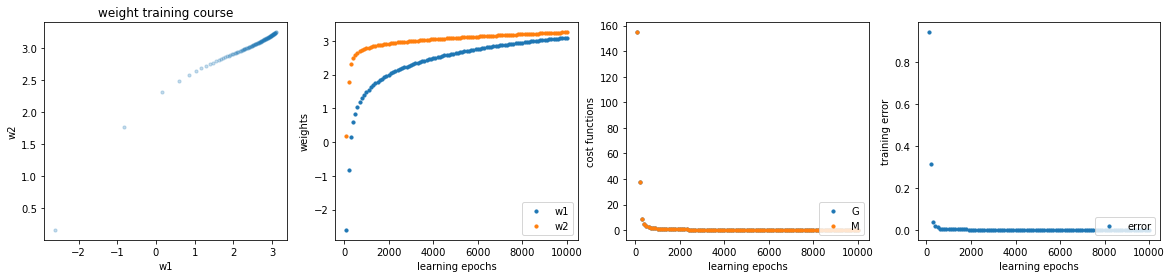

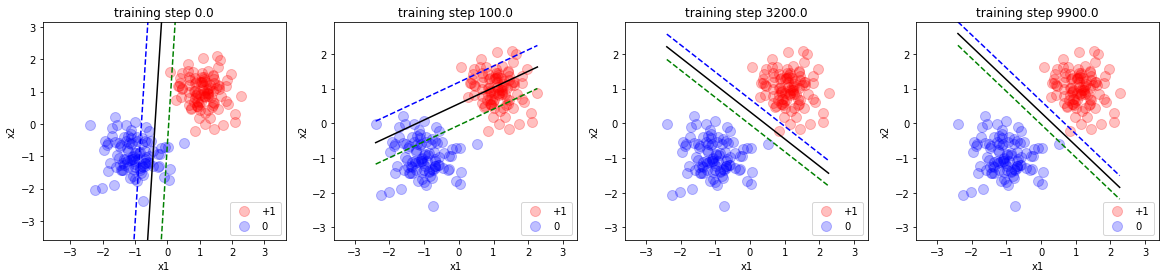

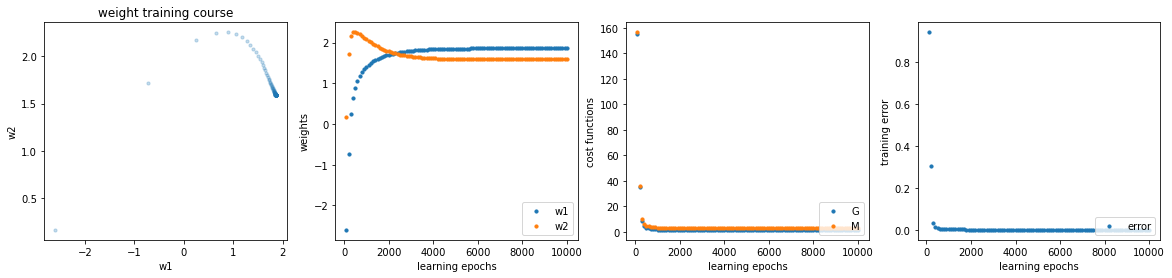

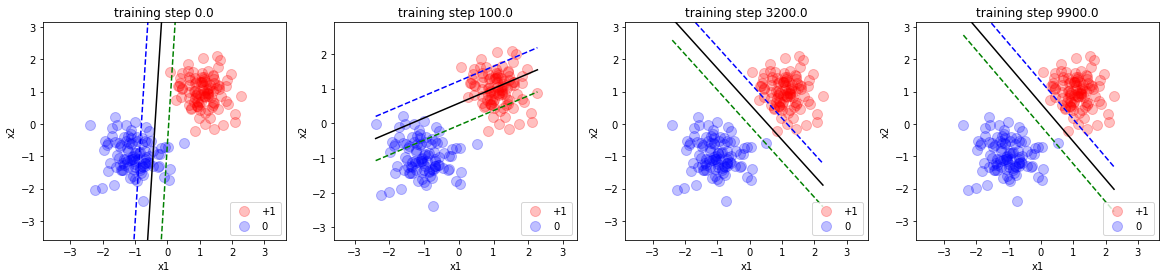

In [4]:
T=10000# number of training steps
stepPlot=T/100 # snapshot of learning

N=2 # two dimensional input
# initialize the weights
w0=2*np.random.randn(N) # gaussian with mean 0 and st=2
print('initial weights %s' % w0)

# learning rate
eta=0.001 # small learning rate is best practice - trade off between learning rate and training epochs T
# weight decay
# alpha=0
alpha_list=[0,0.5]
for i in range(len(alpha_list)):
    alpha=alpha_list[i]
    print('\n with alpha=', alpha)
    
    # training 
    Gplot=[]; Mplot=[]; wplot=[]; yplot=[]; errorPlot=[];

    for step in range(T):
        if step==0: w=w0
        h=x.dot(w) # activation of the perceptron
        y=sigmoid(h,b) # output of the perceptron
        err=y*(1-y)*(z-y)
        gr=-err.dot(x) # gradient of the log-likelihood
        w=w-eta*(gr+alpha*w) # update

        if step % stepPlot==0:
            gtemp=Efunc(w,x,z) # log-likelihood
            Gplot.append(gtemp)
            Mplot.append(gtemp+0.5*alpha*w.dot(w))
            wplot.append(w)
            yplot.append(y)
            errorfrac=sum(abs(np.round(yplot[-1]-z)))/len(z) # training accuracy at last step
            errorPlot.append(errorfrac)
        if step % (stepPlot*10)==0:
            print('{a1} steps, E: {a2:.6e}, errorfrac: {a5}, weights: {a3:.4},{a4:.4}'\
                  .format(a1=step+1,a2=gtemp,a3=w[0],a4=w[1],a5=errorfrac))
            
    # plot evolution of the weights
    fig,ax=plt.subplots(1,4,figsize=(20,4))
    wplot1=np.array(wplot)
    xplot=stepPlot*(np.arange(np.int(T/stepPlot))+1)
    ax[0].scatter(wplot1[:,0],wplot1[:,1],s=10,alpha=0.25)
    ax[0].set_xlabel('w1'); ax[0].set_ylabel('w2'); ax[0].set_title('weight training course')
    for i in range(N):
        ax[1].scatter(xplot,wplot1[:,i],s=10,label='w%s' % (i+1))
        ax[1].legend(loc='lower right'); ax[1].set_xlabel('learning epochs'); ax[1].set_ylabel('weights'); #ax[1].set_xscale('log'
    # plot cost functions
    ax[2].scatter(xplot,np.array(Gplot),s=10,label='G')
    ax[2].scatter(xplot,np.array(Mplot),s=10,label='M')
    ax[2].legend(loc='lower right'); ax[2].set_xlabel('learning epochs'); ax[2].set_ylabel('cost functions'); #ax[1].set_xscale('log')
    # plot error rate on the training set
    ax[3].scatter(xplot,np.array(errorPlot),s=10,label='error')
    ax[3].legend(loc='lower right'); ax[3].set_xlabel('learning epochs'); ax[3].set_ylabel('training error'); #ax[1].set_xscale('log')
    # plt.savefig('figs/CLASS0_WeightTraining_Alpha' + '{}.pdf'.format(alpha), bbox_inches='tight')

    # plot evolution of the classification boundary
    fig,ax=plt.subplots(1,4,figsize=(20,4))
    step=[0,1,int(np.round(wplot1.shape[0]/3))-1,int(np.round(wplot1.shape[0]))-1]

    h25=np.log(0.25/(1-0.25)) # activation corresponding to 0.25 probability of t=1
    h75=np.log(0.75/(1-0.75))# activation corresponding to 0.75 probability of t=1

    for i in range(len(step)):
        size=100
        ax[i].scatter(x[z==1,0],x[z==1,1],s=size,color='red',alpha=0.25,label='+1')
        ax[i].scatter(x[z==0,0],x[z==0,1],s=size,color='blue',alpha=0.25,label='0')
        ax[i].set_xlabel("x1"); ax[i].set_ylabel("x2")
        ax[i].legend(loc='lower right')
        ax[i].axis('equal')
        x1=np.linspace(x[:,0].min(),x[:,0].max(),num=100)
        y0=(-b-wplot1[step[i],0]*x1)/wplot1[step[i],1]    # h=0 activation
        y1=(-b-h25-wplot1[step[i],0]*x1)/wplot1[step[i],1]    # h=+1 activation
        ym1=(-b-h75-wplot1[step[i],0]*x1)/wplot1[step[i],1]   #h=-1 activation
        ax[i].plot(x1,y0,'k'); ax[i].plot(x1,y1,'--b'); ax[i].plot(x1,ym1,'--g');
        ax[i].set_title("training step %s" % (step[i]*stepPlot))
        ax[i].set_xlim(1.5*x1[0],1.5*x1[-1]); ax[i].set_ylim(1.5*x[:,1].min(),1.5*x[:,1].max());
    